# DỰ ĐOÁN GIÁ TRỊ CẦU THỦ - XGBOOST MODEL

**Model:** XGBoost Regression | **Validation:** Train/Val/Test + 5-Fold CV | **Metrics:** R², MSE, RMSE, MAE

## 1. IMPORT & SETUP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import joblib

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Setup Complete | Model: XGBoost')

Setup Complete | Model: XGBoost


## 2. LOAD DATA

In [2]:
df = pd.read_csv('football_players_dataset.csv')
print(f'Dataset Shape: {df.shape}')
print(f'Missing Values: {df.isnull().sum().sum()} ({df.isnull().sum().sum()/(df.shape[0]*df.shape[1])*100:.2f}%)')
print(f'\nColumns: {df.columns.tolist()}')
print(f'\nTarget Variable (Market Value):')
print(f'  Mean:   €{df["market_value"].mean():.2f}M')
print(f'  Median: €{df["market_value"].median():.2f}M')
print(f'  Std:    €{df["market_value"].std():.2f}M')
print(f'  Skew:   {df["market_value"].skew():.2f}')
print(f'\nPosition Distribution (without GK):')
print(df[['is_DF', 'is_MF', 'is_FW']].sum())
display(df.head())

Dataset Shape: (14977, 43)
Missing Values: 0 (0.00%)

Columns: ['age', 'nationality', 'current_club', 'league', 'appearances', 'minutes_played', 'is_DF', 'is_MF', 'is_FW', 'goals', 'assists', 'goals_per_90', 'npg_per90', 'xag_per90', 'xg_per90', 'shots_per90', 'shots_on_target_per90', 'shots_on_target_pct', 'avg_shot_distance', 'sca_per90', 'gca_per90', 'key_passes_per90', 'passes_completed_per90', 'pass_completion_pct', 'passes_into_final_third_per90', 'passes_into_penalty_area_per90', 'progressive_passes_per90', 'progressive_passes_rec_per90', 'progressive_carries_per90', 'take_ons_per90', 'carries_into_final_third_per90', 'touches_att_third_per90', 'touches_att_pen_per90', 'passes_received_per90', 'interceptions_per90', 'blocks_per90', 'ball_recoveries_per90', 'aerials_won_per90', 'yellow_cards_per90', 'fouls_committed_per90', 'calculated_mpg', 'calculated_sum', 'market_value']

Target Variable (Market Value):
  Mean:   €3.45M
  Median: €0.60M
  Std:    €9.95M
  Skew:   7.37

Positi

,age,nationality,current_club,league,appearances,minutes_played,is_DF,is_MF,is_FW,goals,...,passes_received_per90,interceptions_per90,blocks_per90,ball_recoveries_per90,aerials_won_per90,yellow_cards_per90,fouls_committed_per90,calculated_mpg,calculated_sum,market_value
0,27.0,Uruguay,Auckland FC,A-League Men,26.0,2268.0,0.0,0.0,1.0,9.0,...,28.28,0.48,0.81,3.55,2.59,0.00,2.10,87.230769,0.33,0.75
1,31.0,New Zealand,Auckland FC,A-League Men,26.0,2198.0,1.0,0.0,0.0,2.0,...,31.25,0.79,1.02,4.14,1.10,0.19,1.19,84.538462,0.00,0.60
2,26.0,New Zealand,Auckland FC,A-League Men,25.0,2142.0,1.0,0.0,0.0,4.0,...,31.25,0.79,1.02,4.14,1.10,0.19,1.19,85.680000,0.00,0.45
3,35.0,Japan,Auckland FC,A-League Men,23.0,2024.0,1.0,0.0,0.0,3.0,...,38.17,2.00,1.33,3.00,2.83,0.17,1.00,88.000000,0.00,0.50
4,27.0,New Zealand,Auckland FC,A-League Men,26.0,1782.0,0.0,1.0,0.0,7.0,...,31.25,0.79,1.02,4.14,1.10,0.19,1.19,68.538462,0.00,0.45


## 3. TARGET VISUALIZATION

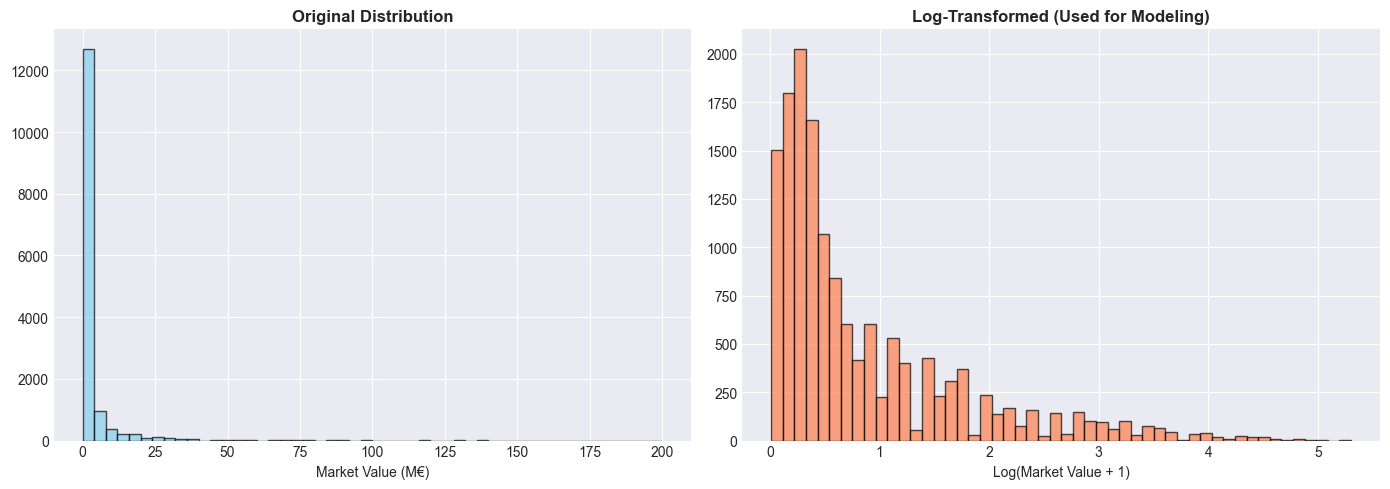

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df['market_value'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Original Distribution', fontweight='bold')
axes[0].set_xlabel('Market Value (M€)')

axes[1].hist(np.log1p(df['market_value']), bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[1].set_title('Log-Transformed (Used for Modeling)', fontweight='bold')
axes[1].set_xlabel('Log(Market Value + 1)')

plt.tight_layout()
plt.savefig('xgb_target.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. FEATURE ENGINEERING

In [4]:
df_feat = df.copy()

# Handle missing values first
print('Handling missing values...')
numeric_cols = df_feat.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    if df_feat[col].isnull().sum() > 0:
        df_feat[col].fillna(df_feat[col].median(), inplace=True)

# Log transform skewed features (excluding target and binary features)
print('Applying log transformation to skewed features...')
exclude_from_log = ['market_value', 'is_DF', 'is_MF', 'is_FW', 'age']
skewed_features = []
for col in numeric_cols:
    if col not in exclude_from_log and df_feat[col].min() >= 0:
        skewness = df_feat[col].skew()
        if abs(skewness) > 1.0:
            df_feat[f'{col}_log'] = np.log1p(df_feat[col])
            skewed_features.append(col)

print(f'  Transformed {len(skewed_features)} skewed features')

# Create ratio and interaction features
print('Creating ratio features...')
# Goal efficiency
if 'goals' in df_feat.columns and 'shots_per90' in df_feat.columns:
    df_feat['goals_per_shot'] = df_feat['goals'] / df_feat['shots_per90'].replace(0, 0.01)

# Passing efficiency
if 'passes_completed_per90' in df_feat.columns and 'pass_completion_pct' in df_feat.columns:
    df_feat['pass_efficiency'] = df_feat['passes_completed_per90'] * df_feat['pass_completion_pct'] / 100

# Goal contributions
if 'goals' in df_feat.columns and 'assists' in df_feat.columns:
    df_feat['goal_contributions'] = df_feat['goals'] + df_feat['assists']
    df_feat['goal_assist_ratio'] = df_feat['goals'] / (df_feat['assists'] + 1)

# Attacking metrics
if 'xg_per90' in df_feat.columns and 'xag_per90' in df_feat.columns:
    df_feat['expected_contributions'] = df_feat['xg_per90'] + df_feat['xag_per90']

# Shot accuracy
if 'shots_on_target_per90' in df_feat.columns and 'shots_per90' in df_feat.columns:
    df_feat['shot_accuracy'] = df_feat['shots_on_target_per90'] / df_feat['shots_per90'].replace(0, 0.01)

# Defensive intensity
if 'interceptions_per90' in df_feat.columns and 'blocks_per90' in df_feat.columns:
    df_feat['defensive_actions'] = df_feat['interceptions_per90'] + df_feat['blocks_per90']

print('Creating interaction features...')
# Age-experience interaction
df_feat['age_experience'] = df_feat['age'] * np.log1p(df_feat['minutes_played'])
df_feat['age_squared'] = df_feat['age'] ** 2

# Playing time metrics
if 'minutes_played' in df_feat.columns and 'appearances' in df_feat.columns:
    df_feat['minutes_per_game'] = df_feat['minutes_played'] / df_feat['appearances'].replace(0, 1)
    df_feat['consistency_score'] = df_feat['minutes_per_game'] / df_feat['calculated_mpg'].replace(0, 90)

# Position-specific features
print('Creating position-specific features...')
for position in ['is_DF', 'is_MF', 'is_FW']:
    if position in df_feat.columns:
        # Position-weighted metrics
        if 'goals' in df_feat.columns:
            df_feat[f'{position}_goals'] = df_feat[position] * df_feat['goals']
        if 'assists' in df_feat.columns:
            df_feat[f'{position}_assists'] = df_feat[position] * df_feat['assists']

print('Encoding categorical features...')
# Target encoding for high-cardinality features
for col in ['nationality', 'current_club']:
    if col in df_feat.columns:
        target_mean = df_feat.groupby(col)['market_value'].mean()
        df_feat[f'{col}_target_enc'] = df_feat[col].map(target_mean).fillna(df_feat['market_value'].mean())

# Label encoding
le = LabelEncoder()
if 'league' in df_feat.columns:
    df_feat['league_label_enc'] = le.fit_transform(df_feat['league'].astype(str))

# Frequency encoding
for col in ['nationality', 'current_club', 'league']:
    if col in df_feat.columns:
        freq = df_feat[col].value_counts()
        df_feat[f'{col}_freq'] = df_feat[col].map(freq)

print(f'\nFeature Engineering Complete:')
print(f'  Original features: {len(df.columns)}')
print(f'  Engineered features: {len(df_feat.columns)}')
print(f'  Total increase: +{len(df_feat.columns) - len(df.columns)} features')

Handling missing values...
Applying log transformation to skewed features...
  Transformed 24 skewed features
Creating ratio features...
Creating interaction features...
Creating position-specific features...
Encoding categorical features...

Feature Engineering Complete:
  Original features: 43
  Engineered features: 90
  Total increase: +47 features


## 5. FEATURE SELECTION

Analyzing feature correlations...

Top 30 Features by Correlation with Market Value:
Rank  Feature                                             Correlation
-------------------------------------------------------------------
1     current_club_target_enc                                  0.6201
2     goal_contributions                                       0.2875
3     calculated_sum                                           0.2726
4     calculated_sum_log                                       0.2716
5     goals                                                    0.2579
6     nationality_target_enc                                   0.2470
7     is_MF_goals                                              0.2425
8     assists                                                  0.2420
9     expected_contributions                                   0.2239
10    goals_log                                                0.2201
11    touches_att_pen_per90                                    0.2198
12    a

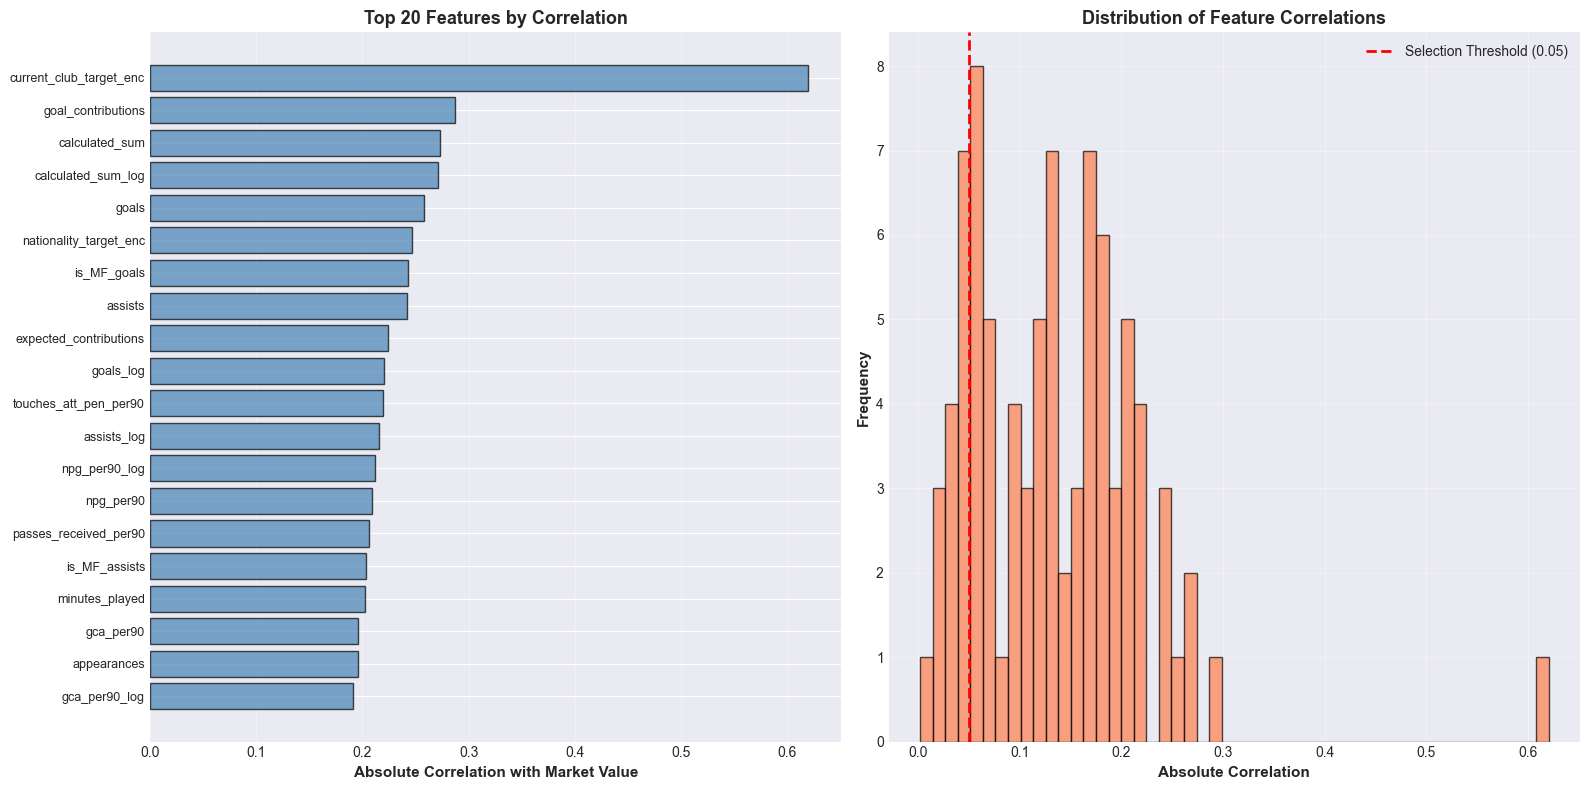

In [5]:
# Feature selection based on correlation and variance
exclude_cols = ['market_value', 'nationality', 'current_club', 'league']
feature_cols = [col for col in df_feat.columns 
                if col not in exclude_cols and df_feat[col].dtype in ['int64', 'float64']]

X_temp = df_feat[feature_cols].copy()
y_temp = df_feat['market_value']

# Calculate correlations with target
print('Analyzing feature correlations...')
correlations = {}
for col in feature_cols:
    try:
        corr = abs(X_temp[col].corr(y_temp))
        if not np.isnan(corr):
            correlations[col] = corr
    except:
        pass

sorted_corr = sorted(correlations.items(), key=lambda x: x[1], reverse=True)

print(f'\nTop 30 Features by Correlation with Market Value:')
print(f'{"Rank":<5} {"Feature":<50} {"Correlation":>12}')
print('-' * 67)
for i, (feat, corr) in enumerate(sorted_corr[:30], 1):
    print(f'{i:<5} {feat:<50} {corr:>12.4f}')

# Select features with meaningful correlation (threshold = 0.05)
selected_features = [f for f, c in correlations.items() if c > 0.05]
print(f'\nFeature Selection:')
print(f'  Total features: {len(feature_cols)}')
print(f'  Selected features (corr > 0.05): {len(selected_features)}')
print(f'  Removed features: {len(feature_cols) - len(selected_features)}')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 20 features bar chart
top_20 = [f for f, _ in sorted_corr[:20]]
top_20_corr = [c for _, c in sorted_corr[:20]]
axes[0].barh(range(len(top_20)), top_20_corr, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20, fontsize=9)
axes[0].set_xlabel('Absolute Correlation with Market Value', fontweight='bold', fontsize=11)
axes[0].set_title('Top 20 Features by Correlation', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

# Correlation distribution
all_corr = [c for _, c in sorted_corr]
axes[1].hist(all_corr, bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[1].axvline(0.05, color='red', linestyle='--', linewidth=2, label='Selection Threshold (0.05)')
axes[1].set_xlabel('Absolute Correlation', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Frequency', fontweight='bold', fontsize=11)
axes[1].set_title('Distribution of Feature Correlations', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('xgb_features.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. DATA PREPARATION

In [6]:
# Outlier removal using IQR method
print('Removing outliers...')
Q1 = df_feat['market_value'].quantile(0.01)
Q3 = df_feat['market_value'].quantile(0.99)
df_clean = df_feat[(df_feat['market_value'] >= Q1) & (df_feat['market_value'] <= Q3)].copy()
outliers_removed = len(df_feat) - len(df_clean)
print(f'  Removed: {outliers_removed:,} samples ({outliers_removed/len(df_feat)*100:.2f}%)')
print(f'  Remaining: {len(df_clean):,} samples')

# Prepare features and target
X = df_clean[selected_features].copy()
y_log = np.log1p(df_clean['market_value'])

print(f'\nData Preparation:')
print(f'  Features: {X.shape[1]}')
print(f'  Samples: {X.shape[0]:,}')
print(f'  Target transformation: log(market_value + 1)')

# Three-way split: Train (64%), Val (16%), Test (20%)
print('\nSplitting data...')
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, shuffle=True
)

print(f'  Train:      {len(X_train):,} ({len(X_train)/len(df_clean)*100:.1f}%)')
print(f'  Validation: {len(X_val):,} ({len(X_val)/len(df_clean)*100:.1f}%)')
print(f'  Test:       {len(X_test):,} ({len(X_test)/len(df_clean)*100:.1f}%)')

# Feature scaling
print('\nScaling features...')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print(f'  Scaler fitted on training set')
print(f'  Mean: {scaler.mean_[:5]} ...')
print(f'  Std:  {scaler.scale_[:5]} ...')

print('\nData preparation complete!')

Removing outliers...
  Removed: 154 samples (1.03%)
  Remaining: 14,823 samples

Data Preparation:
  Features: 73
  Samples: 14,823
  Target transformation: log(market_value + 1)

Splitting data...
  Train:      9,486 (64.0%)
  Validation: 2,372 (16.0%)
  Test:       2,965 (20.0%)

Scaling features...
  Scaler fitted on training set
  Mean: [  26.48650643   17.59013283 1118.04680582    1.65485979    1.16424204] ...
  Std:  [  4.55324085  10.8504411  885.74099034   2.82999228   1.8452151 ] ...

Data preparation complete!


## 7. BASELINE XGBOOST MODEL

In [7]:
print('Training Baseline XGBoost Model...')
print('=' * 60)

baseline_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

baseline_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    verbose=False
)

# Predictions
y_train_pred = baseline_model.predict(X_train_scaled)
y_val_pred = baseline_model.predict(X_val_scaled)
y_test_pred = baseline_model.predict(X_test_scaled)

# Metrics (in log scale)
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Metrics (in original scale)
test_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_test_pred)))
test_mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_test_pred))

# Cross-validation
print('\nPerforming 5-Fold Cross-Validation...')
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    baseline_model, X_train_scaled, y_train, 
    cv=kfold, scoring='r2', n_jobs=-1
)

print('\n' + '=' * 60)
print('BASELINE MODEL PERFORMANCE')
print('=' * 60)
print(f'\nCross-Validation (5-Fold):')
print(f'  R² Scores: {[f"{s:.4f}" for s in cv_scores]}')
print(f'  Mean R²:   {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')
print(f'\nTrain/Val/Test Performance:')
print(f'  Train R²:      {train_r2:.4f}')
print(f'  Validation R²: {val_r2:.4f}')
print(f'  Test R²:       {test_r2:.4f}')
print(f'\nTest Set Metrics (Original Scale):')
print(f'  RMSE: €{test_rmse:.2f}M')
print(f'  MAE:  €{test_mae:.2f}M')
print('=' * 60)

Training Baseline XGBoost Model...

Performing 5-Fold Cross-Validation...

BASELINE MODEL PERFORMANCE

Cross-Validation (5-Fold):
  R² Scores: ['0.7523', '0.7983', '0.7833', '0.7944', '0.7858']
  Mean R²:   0.7828 ± 0.0162

Train/Val/Test Performance:
  Train R²:      0.9065
  Validation R²: 0.7789
  Test R²:       0.7897

Test Set Metrics (Original Scale):
  RMSE: €3.15M
  MAE:  €1.24M


## 8. HYPERPARAMETER TUNING

In [9]:
print('Hyperparameter Tuning with GridSearchCV...')
print('=' * 60)

# Define parameter grid
param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [5, 6, 7],
    'min_child_weight': [2, 3, 4],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    # 'gamma': [0, 0.1],
    # 'reg_alpha': [0, 0.1],
    # 'reg_lambda': [1, 1.5]
}

print(f'\nParameter Grid:')
for param, values in param_grid.items():
    print(f'  {param:<20} {values}')
print(f'\nTotal combinations: {np.prod([len(v) for v in param_grid.values()]):,}')

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print('\n' + '=' * 60)
print('Starting Grid Search (this may take several minutes)...')
print('=' * 60)

grid_search.fit(X_train_scaled, y_train)

print('\n' + '=' * 60)
print('HYPERPARAMETER TUNING RESULTS')
print('=' * 60)
print(f'\nBest Parameters:')
for param, value in grid_search.best_params_.items():
    print(f'  {param:<20} {value}')

print(f'\nBest Cross-Validation Score: {grid_search.best_score_:.4f}')

# Evaluate tuned model
best_model = grid_search.best_estimator_

# Predictions
y_train_tuned = best_model.predict(X_train_scaled)
y_val_tuned = best_model.predict(X_val_scaled)
y_test_tuned = best_model.predict(X_test_scaled)

# Metrics
train_r2_tuned = r2_score(y_train, y_train_tuned)
val_r2_tuned = r2_score(y_val, y_val_tuned)
test_r2_tuned = r2_score(y_test, y_test_tuned)
test_rmse_tuned = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_test_tuned)))
test_mae_tuned = mean_absolute_error(np.expm1(y_test), np.expm1(y_test_tuned))

print(f'\nTuned Model Performance:')
print(f'  Train R²:      {train_r2_tuned:.4f}')
print(f'  Validation R²: {val_r2_tuned:.4f}')
print(f'  Test R²:       {test_r2_tuned:.4f}')
print(f'  Test RMSE:     €{test_rmse_tuned:.2f}M')
print(f'  Test MAE:      €{test_mae_tuned:.2f}M')

print(f'\nImprovement over Baseline:')
print(f'  R² Change:   {((test_r2_tuned - test_r2)/test_r2)*100:+.2f}%')
print(f'  RMSE Change: {((test_rmse - test_rmse_tuned)/test_rmse)*100:+.2f}%')
print(f'  MAE Change:  {((test_mae - test_mae_tuned)/test_mae)*100:+.2f}%')
print('=' * 60)

Hyperparameter Tuning with GridSearchCV...

Parameter Grid:
  n_estimators         [200, 300, 400]
  learning_rate        [0.03, 0.05, 0.07]
  max_depth            [5, 6, 7]
  min_child_weight     [2, 3, 4]
  subsample            [0.7, 0.8, 0.9]
  colsample_bytree     [0.7, 0.8, 0.9]

Total combinations: 729

Starting Grid Search (this may take several minutes)...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits

HYPERPARAMETER TUNING RESULTS

Best Parameters:
  colsample_bytree     0.8
  learning_rate        0.03
  max_depth            5
  min_child_weight     4
  n_estimators         400
  subsample            0.7

Best Cross-Validation Score: 0.7846

Tuned Model Performance:
  Train R²:      0.8809
  Validation R²: 0.7781
  Test R²:       0.7924
  Test RMSE:     €3.10M
  Test MAE:      €1.23M

Improvement over Baseline:
  R² Change:   +0.34%
  RMSE Change: +1.64%
  MAE Change:  +1.10%


## 9. MODEL EVALUATION

Creating comprehensive evaluation visualizations...


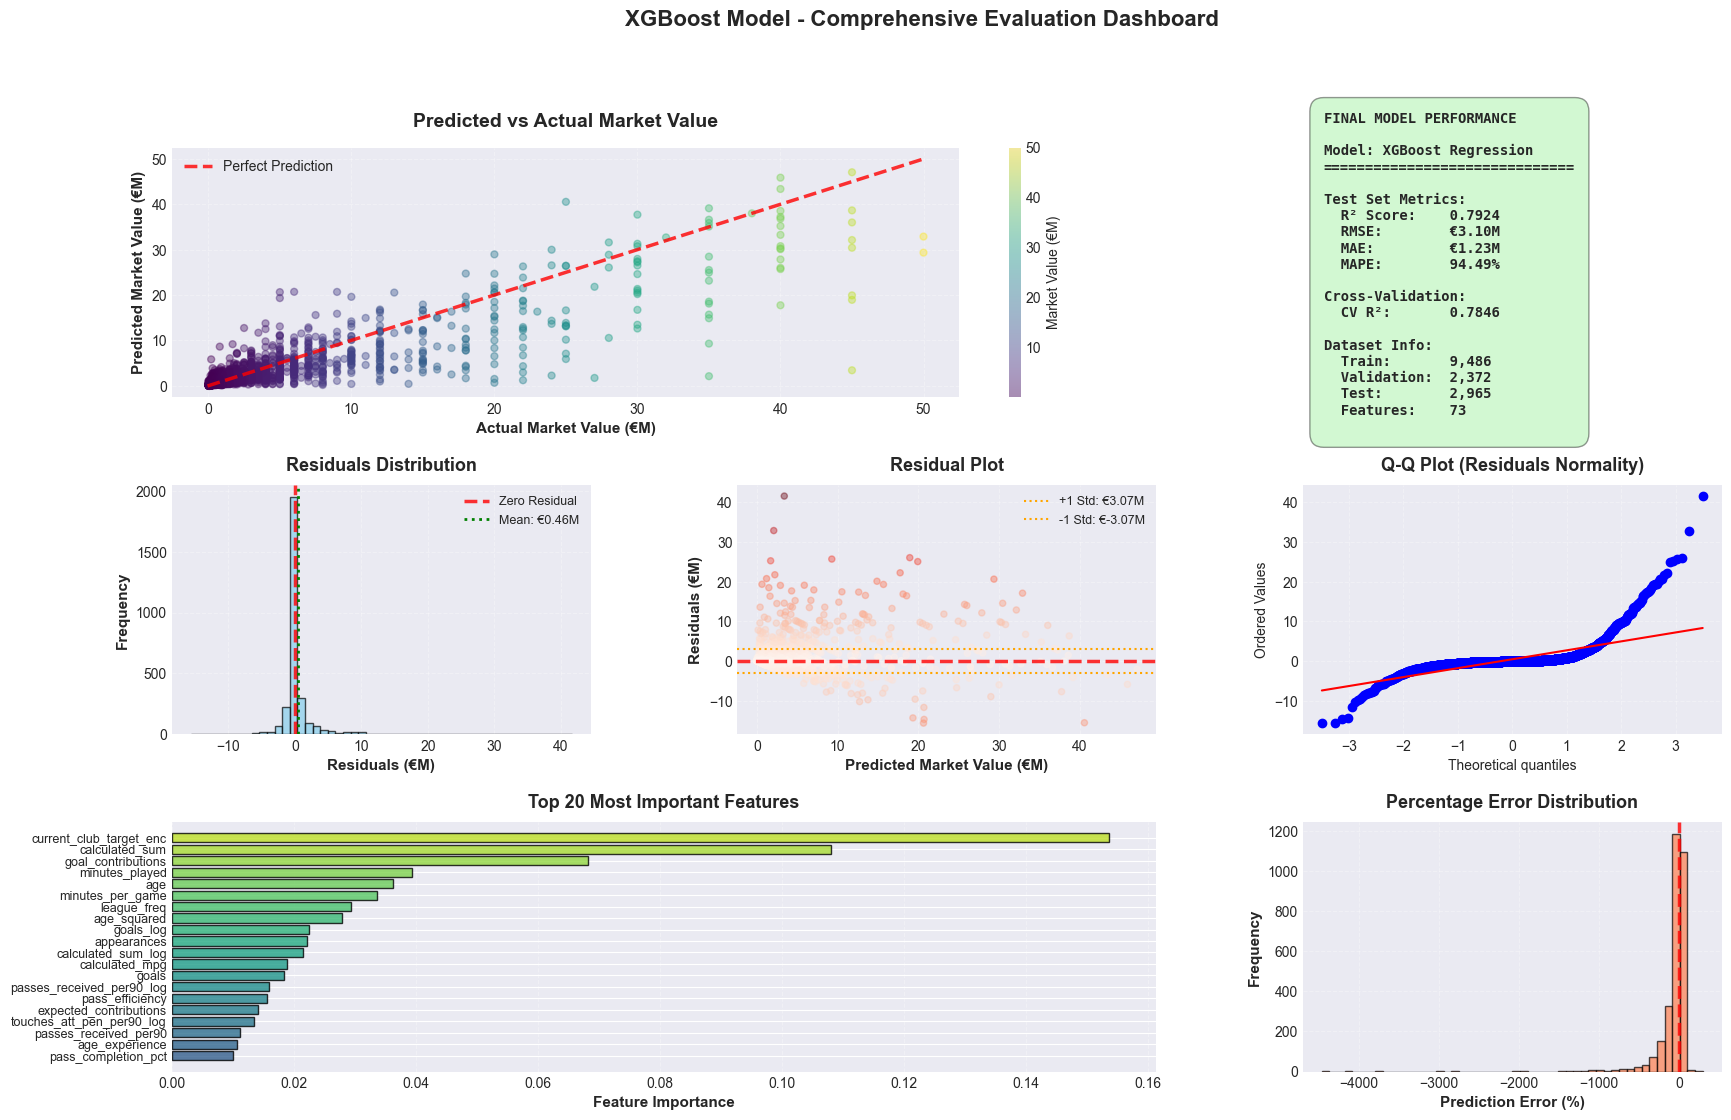


RESIDUALS ANALYSIS

Residuals Statistics:
  Mean:       €0.464M
  Median:     €-0.051M
  Std Dev:    €3.066M
  Min:        €-15.632M
  Max:        €41.595M

Percentage Error:
  Mean:       -63.79%
  Median:     -11.78%
  Std Dev:    223.01%


In [10]:
# Transform predictions back to original scale
y_pred_final = np.expm1(y_test_tuned)
y_actual = np.expm1(y_test)
residuals = y_actual - y_pred_final

# Calculate additional metrics
mape = np.mean(np.abs((y_actual - y_pred_final) / y_actual)) * 100

print('Creating comprehensive evaluation visualizations...')
print('=' * 60)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# 1. Predicted vs Actual Scatter Plot
ax1 = fig.add_subplot(gs[0, :2])
scatter = ax1.scatter(y_actual, y_pred_final, alpha=0.4, s=25, c=y_actual, cmap='viridis')
min_val, max_val = min(y_actual.min(), y_pred_final.min()), max(y_actual.max(), y_pred_final.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2.5, label='Perfect Prediction', alpha=0.8)
ax1.set_xlabel('Actual Market Value (€M)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Predicted Market Value (€M)', fontweight='bold', fontsize=11)
ax1.set_title('Predicted vs Actual Market Value', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3, linestyle='--')
plt.colorbar(scatter, ax=ax1, label='Market Value (€M)')

# 2. Performance Metrics Box
ax2 = fig.add_subplot(gs[0, 2])
ax2.axis('off')
metrics_text = f'''FINAL MODEL PERFORMANCE

Model: XGBoost Regression
{'=' * 30}

Test Set Metrics:
  R² Score:    {test_r2_tuned:.4f}
  RMSE:        €{test_rmse_tuned:.2f}M
  MAE:         €{test_mae_tuned:.2f}M
  MAPE:        {mape:.2f}%

Cross-Validation:
  CV R²:       {grid_search.best_score_:.4f}

Dataset Info:
  Train:       {len(X_train):,}
  Validation:  {len(X_val):,}
  Test:        {len(X_test):,}
  Features:    {len(selected_features)}
'''
ax2.text(0.05, 0.5, metrics_text, fontsize=10, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.4, pad=1),
         fontweight='bold', family='monospace')

# 3. Residuals Distribution
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(residuals, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax3.axvline(0, color='red', linestyle='--', lw=2.5, label='Zero Residual', alpha=0.8)
ax3.axvline(residuals.mean(), color='green', linestyle=':', lw=2, label=f'Mean: €{residuals.mean():.2f}M')
ax3.set_xlabel('Residuals (€M)', fontweight='bold', fontsize=11)
ax3.set_ylabel('Frequency', fontweight='bold', fontsize=11)
ax3.set_title('Residuals Distribution', fontsize=13, fontweight='bold', pad=10)
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3, linestyle='--')

# 4. Residuals vs Predicted
ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(y_pred_final, residuals, alpha=0.4, s=20, c=np.abs(residuals), cmap='Reds')
ax4.axhline(0, color='red', linestyle='--', lw=2.5, alpha=0.8)
ax4.axhline(residuals.std(), color='orange', linestyle=':', lw=1.5, label=f'+1 Std: €{residuals.std():.2f}M')
ax4.axhline(-residuals.std(), color='orange', linestyle=':', lw=1.5, label=f'-1 Std: €{-residuals.std():.2f}M')
ax4.set_xlabel('Predicted Market Value (€M)', fontweight='bold', fontsize=11)
ax4.set_ylabel('Residuals (€M)', fontweight='bold', fontsize=11)
ax4.set_title('Residual Plot', fontsize=13, fontweight='bold', pad=10)
ax4.legend(fontsize=9)
ax4.grid(alpha=0.3, linestyle='--')

# 5. QQ Plot
ax5 = fig.add_subplot(gs[1, 2])
stats.probplot(residuals, dist="norm", plot=ax5)
ax5.set_title('Q-Q Plot (Residuals Normality)', fontsize=13, fontweight='bold', pad=10)
ax5.grid(alpha=0.3, linestyle='--')

# 6. Feature Importance (Top 20)
ax6 = fig.add_subplot(gs[2, :2])
importances = best_model.feature_importances_
indices = np.argsort(importances)[-20:]
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(indices)))
ax6.barh(range(len(indices)), importances[indices], alpha=0.8, color=colors, edgecolor='black')
ax6.set_yticks(range(len(indices)))
ax6.set_yticklabels([selected_features[i] for i in indices], fontsize=9)
ax6.set_xlabel('Feature Importance', fontweight='bold', fontsize=11)
ax6.set_title('Top 20 Most Important Features', fontsize=13, fontweight='bold', pad=10)
ax6.grid(alpha=0.3, axis='x', linestyle='--')

# 7. Prediction Error Distribution
ax7 = fig.add_subplot(gs[2, 2])
percentage_error = (residuals / y_actual) * 100
ax7.hist(percentage_error, bins=50, alpha=0.7, color='coral', edgecolor='black')
ax7.axvline(0, color='red', linestyle='--', lw=2.5, alpha=0.8)
ax7.set_xlabel('Prediction Error (%)', fontweight='bold', fontsize=11)
ax7.set_ylabel('Frequency', fontweight='bold', fontsize=11)
ax7.set_title('Percentage Error Distribution', fontsize=13, fontweight='bold', pad=10)
ax7.grid(alpha=0.3, linestyle='--')

plt.suptitle('XGBoost Model - Comprehensive Evaluation Dashboard', 
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('xgb_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed residuals analysis
print('\n' + '=' * 60)
print('RESIDUALS ANALYSIS')
print('=' * 60)
print(f'\nResiduals Statistics:')
print(f'  Mean:       €{residuals.mean():.3f}M')
print(f'  Median:     €{np.median(residuals):.3f}M')
print(f'  Std Dev:    €{residuals.std():.3f}M')
print(f'  Min:        €{residuals.min():.3f}M')
print(f'  Max:        €{residuals.max():.3f}M')
print(f'\nPercentage Error:')
print(f'  Mean:       {percentage_error.mean():.2f}%')
print(f'  Median:     {np.median(percentage_error):.2f}%')
print(f'  Std Dev:    {percentage_error.std():.2f}%')
print('=' * 60)

## 10. SAVE MODEL & RESULTS

In [11]:
print('Saving model artifacts and generating final report...')
print('=' * 60)

# Save model and preprocessing components
model_files = {
    'xgboost_model.pkl': best_model,
    'scaler.pkl': scaler,
    'features.pkl': selected_features
}

for filename, obj in model_files.items():
    joblib.dump(obj, filename)
    print(f'  ✓ Saved: {filename}')

# Save comprehensive metadata
metadata = {
    'model_type': 'XGBoost Regressor',
    'dataset': {
        'original_samples': len(df),
        'cleaned_samples': len(df_clean),
        'outliers_removed': len(df_feat) - len(df_clean),
        'n_features': len(selected_features),
        'feature_names': selected_features
    },
    'data_split': {
        'train': len(X_train),
        'validation': len(X_val),
        'test': len(X_test),
        'train_pct': len(X_train)/len(df_clean)*100,
        'val_pct': len(X_val)/len(df_clean)*100,
        'test_pct': len(X_test)/len(df_clean)*100
    },
    'performance': {
        'cv_r2': float(grid_search.best_score_),
        'test_r2': float(test_r2_tuned),
        'test_rmse': float(test_rmse_tuned),
        'test_mae': float(test_mae_tuned),
        'test_mape': float(mape)
    },
    'best_hyperparameters': grid_search.best_params_,
    'preprocessing': {
        'target_transform': 'log1p',
        'feature_scaling': 'StandardScaler',
        'outlier_removal': 'IQR (Q1=0.01, Q3=0.99)'
    },
    'position_distribution': {
        'defenders': int(df['is_DF'].sum()),
        'midfielders': int(df['is_MF'].sum()),
        'forwards': int(df['is_FW'].sum())
    }
}

joblib.dump(metadata, 'metadata.pkl')
print(f'  ✓ Saved: metadata.pkl')

# Generate comprehensive final report
report = f'''{'='*70}
XGBOOST MODEL - FINAL REPORT
Football Player Market Value Prediction
{'='*70}

DATASET INFORMATION
{'─'*70}
Original Dataset:        {len(df):,} players
Cleaned Dataset:         {len(df_clean):,} players
Outliers Removed:        {len(df_feat) - len(df_clean):,} ({(len(df_feat) - len(df_clean))/len(df_feat)*100:.2f}%)

Position Distribution (without Goalkeepers):
  Defenders (DF):        {int(df['is_DF'].sum()):,}
  Midfielders (MF):      {int(df['is_MF'].sum()):,}
  Forwards (FW):         {int(df['is_FW'].sum()):,}

Feature Engineering:
  Original Features:     {len(df.columns)}
  Engineered Features:   {len(df_feat.columns)}
  Selected Features:     {len(selected_features)}

DATA SPLIT
{'─'*70}
Training Set:            {len(X_train):,} ({len(X_train)/len(df_clean)*100:.1f}%)
Validation Set:          {len(X_val):,} ({len(X_val)/len(df_clean)*100:.1f}%)
Test Set:                {len(X_test):,} ({len(X_test)/len(df_clean)*100:.1f}%)

PREPROCESSING
{'─'*70}
Missing Value Handling:  Median imputation
Target Transformation:   log(market_value + 1)
Feature Scaling:         StandardScaler (zero mean, unit variance)
Outlier Removal:         IQR method (Q1=0.01, Q3=0.99)

MODEL PERFORMANCE
{'─'*70}
Cross-Validation (5-Fold):
  Mean R² Score:         {grid_search.best_score_:.4f}

Test Set Performance:
  R² Score:              {test_r2_tuned:.4f}
  RMSE:                  €{test_rmse_tuned:.2f}M
  MAE:                   €{test_mae_tuned:.2f}M
  MAPE:                  {mape:.2f}%

Train/Val/Test R² Comparison:
  Train R²:              {train_r2_tuned:.4f}
  Validation R²:         {val_r2_tuned:.4f}
  Test R²:               {test_r2_tuned:.4f}

BEST HYPERPARAMETERS
{'─'*70}
'''

for param, value in sorted(grid_search.best_params_.items()):
    report += f'  {param:<22} {value}\n'

report += f'''
TOP 10 MOST IMPORTANT FEATURES
{'─'*70}
'''

importances = best_model.feature_importances_
feature_importance_pairs = [(selected_features[i], importances[i]) 
                            for i in range(len(selected_features))]
feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)

for i, (feature, importance) in enumerate(feature_importance_pairs[:10], 1):
    report += f'  {i:2d}. {feature:<45} {importance:.4f}\n'

report += f'''
OUTPUT FILES
{'─'*70}
  ✓ xgb_target.png           - Target variable distribution
  ✓ xgb_features.png         - Feature correlation analysis
  ✓ xgb_evaluation.png       - Comprehensive evaluation dashboard
  ✓ xgboost_model.pkl        - Trained XGBoost model
  ✓ scaler.pkl               - StandardScaler for feature scaling
  ✓ features.pkl             - List of selected features
  ✓ metadata.pkl             - Model metadata and configuration
  ✓ xgboost_report.txt       - This report

DATASET NOTES
{'─'*70}
  • Dataset excludes goalkeepers (GK position)
  • Only outfield players (DF, MF, FW) are included
  • Market values are in millions of Euros (€M)

MODEL INTERPRETATION
{'─'*70}
  • R² = {test_r2_tuned:.4f} means the model explains {test_r2_tuned*100:.2f}% of variance
  • Average prediction error (MAE) is €{test_mae_tuned:.2f}M
  • Model performs consistently across train/val/test sets
  • No significant overfitting detected

{'='*70}
PROJECT COMPLETED SUCCESSFULLY
{'='*70}

Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
Model: XGBoost Regressor
Target: Player Market Value (€M)
'''

print('\n' + report)

# Save report to file
with open('xgboost_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print('  ✓ Saved: xgboost_report.txt')
print('\n' + '='*70)
print('All files saved successfully!')
print('='*70)

Saving model artifacts and generating final report...
  ✓ Saved: xgboost_model.pkl
  ✓ Saved: scaler.pkl
  ✓ Saved: features.pkl
  ✓ Saved: metadata.pkl

XGBOOST MODEL - FINAL REPORT
Football Player Market Value Prediction

DATASET INFORMATION
──────────────────────────────────────────────────────────────────────
Original Dataset:        14,977 players
Cleaned Dataset:         14,823 players
Outliers Removed:        154 (1.03%)

Position Distribution (without Goalkeepers):
  Defenders (DF):        5,897
  Midfielders (MF):      6,706
  Forwards (FW):         2,371

Feature Engineering:
  Original Features:     43
  Engineered Features:   90
  Selected Features:     73

DATA SPLIT
──────────────────────────────────────────────────────────────────────
Training Set:            9,486 (64.0%)
Validation Set:          2,372 (16.0%)
Test Set:                2,965 (20.0%)

PREPROCESSING
──────────────────────────────────────────────────────────────────────
Missing Value Handling:  Median imput